# CSE527 Homework2
**Due date: 23:59 on Oct 11, 2018 (Thursday)**

## Description
---
In this homework you will experiment with SIFT features for scene matching and object recognition. You will work with the SIFT tutorial and code from the University of Toronto. In the compressed homework file (hw2_files.zip), you will find the tutorial document (tutSIFT04.pdf) and a paper from the International Journal of Computer Vision (ijcv04.pdf) describing SIFT and object recognition. Although the tutorial document assumes matlab implemention, you should still be able to follow the technical details in it. In addition, you are **STRONGLY** encouraged to read this paper unless you’re already quite familiar with matching and recognition using SIFT.

There are 3 problems in this homework with a total of 100 points. Two bonus questions with extra 5 and 15 points are provided under problem 1 and 2 respectively. The maximum points you may earn from this homework is 100 + 20 = 120 points. Be sure to read **Submission Guidelines** below. They are important.

## Using SIFT in OpenCV 3.x.x
---
Feature descriptors like SIFT and SURF are no longer included in OpenCV since version 3. This section provides instructions on how to use SIFT for those who use OpenCV 3.x.x. If you are using OpenCV 2.x.x then you are all set, please skip this section. Read this if you are curious about why SIFT is removed https://www.pyimagesearch.com/2015/07/16/where-did-sift-and-surf-go-in-opencv-3/.

One simple way to use the OpenCV in-built function `SIFT` is to switch back to version 2.x.x, but if you want to keep using OpenCV 3.x.x, do the following:
1. uninstall your original OpenCV package
2. install opencv-contrib-python using pip (pip is a Python tool for installing packages written in Python), please find detailed instructions at https://pypi.python.org/pypi/opencv-contrib-python

After you have your OpenCV set up, you should be able to use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

In [10]:
# import packages here
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.signal import convolve2d
import math

## Problem 1: Match transformed images using SIFT features
{40 points + bonus 5} You will transform a given image, and match it back to the original image using SIFT keypoints.

- **Step 1 (5pt)**. Use the function from SIFT class to detect keypoints from the given image. Plot the image with keypoints scale and orientation overlaid.

- **Step 2 (10pt)**. Rotate your image counter clockwise by 80 degrees with the `cv2.warpAffine` function. Extract SIFT keypoints for this rotated image and plot the rotated picture with keypoints scale and orientation overlaid just as in step 1.

- **Step 3 (15pt)**. Match the SIFT keypoints of the original image and the rotated imag using the `knnMatch` function in the `cv2.BFMatcher` class. Discard bad matches using the ratio test proposed by D.Lowe in the SIFT paper. Use **0.1** as the ratio in this homework. Note that this is for display purpose only. Draw the filtered good keypoint matches on the image and display it. The image you draw should have two images side by side with matching lines across them.

- **Step 4 (10pt)**. Use the RANSAC algorithm to find the affine transformation from the rotated image to the original image. You are not required to implement the RANSAC algorithm yourself, instead you could use the `cv2.findHomography` function (set the 3rd parameter `method` to `cv2.RANSAC`) to compute the transformation matrix. Transform the rotated image back using this matrix and the `cv2.warpPerspective` function. Display the recovered image.

- **Bonus (5pt)**. You might have noticed that the rotated image from step 2 is cropped. Rotate the image without any cropping and you will be awarded an extra 5 points.

In [11]:
cv2.ocl.setUseOpenCL(False)

res3 shape is
(449L, 784L, 3L)
Transformation Matrix = 
[[  1.73565412e-01  -9.84812392e-01   3.87733659e+02]
 [  9.84895595e-01   1.73675161e-01  -6.80402202e+01]
 [  9.89842199e-08   3.73005083e-09   1.00000000e+00]]


(-0.5, 399.5, 319.5, -0.5)

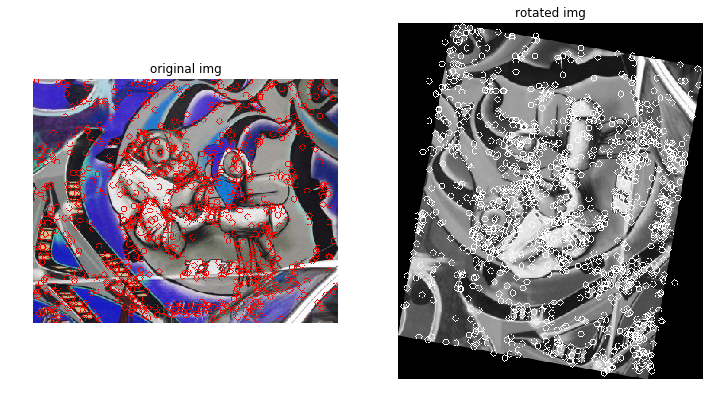

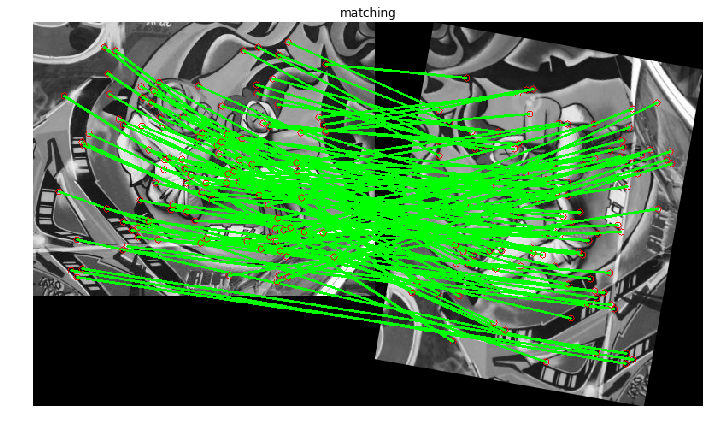

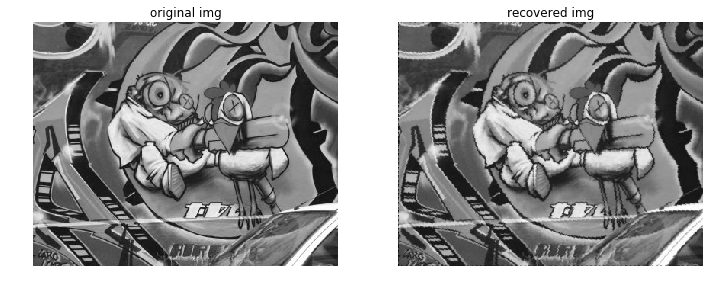

In [12]:
def drawMatches(img1, kp1, img2, kp2, matches): 
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])
    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)
    return out

def rotateImage(img_input):
    height, width = img_input.shape
    img_center = (width/2, height/2)
    rot_mat = cv2.getRotationMatrix2D(img_center, 80, 1.0)
    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rot_mat[0,0]) 
    abs_sin = abs(rot_mat[0,1])
    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)
    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rot_mat[0, 2] += bound_w/2 - img_center[0]
    rot_mat[1, 2] += bound_h/2 - img_center[1]
    # rotate image with the new bounds and translated rotation matrix
    # rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    rotated_img = cv2.warpAffine(img_input, rot_mat, (bound_w,bound_h), flags=cv2.INTER_LINEAR)
    return rotated_img

    


img_input = cv2.imread('SourceImages/sift_input.jpg') # if with no 0, then not gray scale
gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY) 
sift = cv2.xfeatures2d.SIFT_create()
(kp, descs) = sift.detectAndCompute(gray, None)
for elements in kp:
    (x1,y1) = elements.pt
    cv2.circle(img_input, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
# ===== This is your first output =====
res1=img_input

img_input = cv2.imread('SourceImages/sift_input.jpg', 0)
rotated_img=rotateImage(img_input)
sift = cv2.xfeatures2d.SIFT_create()
(kp, descs) = sift.detectAndCompute(rotated_img, None)
for elements in kp:
    (x1,y1) = elements.pt
    cv2.circle(rotated_img, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
# ===== This is your second output =====
res2 = rotated_img

# ====== Plot functions, DO NOT CHANGE =====
# Plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(res1, 'gray')
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res2, 'gray')
plt.title('rotated img')
plt.axis('off')
# ==========================================

# compute feature matching
img_input = cv2.imread('SourceImages/sift_input.jpg', 0)
rotated_img=rotateImage(img_input)
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_input,None)
kp2, des2 = sift.detectAndCompute(rotated_img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.1*n.distance:
        good_matches.append(m)
# draw matching results with the given drawMatches function
# ===== This is your third output =====
res3=drawMatches(img_input, kp1, rotated_img, kp2, good_matches)
print("res3 shape is")
print(res3.shape)
# ====== Plot functions, DO NOT CHANGE =====
plt.figure(figsize=(12,8))
plt.imshow(res3)
plt.title('matching')
plt.axis('off')
# ==========================================

# estimate similarity transform
# find perspective transform matrix using RANSAC
#     rot, mask =    PROVIDED IN THE PROBLEM SHOULD UNCOMMENT IT 
if len(good_matches) > 4:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    rot, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0) #cv2.RANSAC
    print "Transformation Matrix = \n", rot  
    # mapping rotataed image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    width=img_input.shape[0]
    height=img_input.shape[1]
    res4=cv2.warpPerspective(rotated_img, rot, (height,width), cv2.WARP_FILL_OUTLIERS, 200)
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)

# ====== Plot functions, DO NOT CHANGE =====
# plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('off')
# ==========================================

## Problem 2: Scene stitching with SIFT features
{30 points + 15 bonus} You will match and align between different views of a scene with SIFT features. 

Use `cv2.copyMakeBorder` function to pad the center image with zeros into a larger size. *Hint: the final output image should be of size 1608 × 1312.* Extract SIFT features for all images and go through the same procedures as you did in problem 1. Your goal is to find the affine transformation between the two images and then align one of your images to the other using `cv2.warpPerspective`. Use the `cv2.addWeighted` function to blend the aligned images and show the stitched result. Examples can be found at http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html.
Use parameters **0.5 and 0.5** for alpha blending.

- **Step 1 (15pt)**. Compute the transformation from the right image to the center image. Warp the right image with the computed transformation. Stitch the center and right images with alpha blending. Display the SIFT feature matching between the center and right images like you did in problem 1. Display the stitched result (center and right image).

- **Step 2 (15pt)** Compute the transformation from the left image to the stitched image from step 1. Warp the left image with the computed transformation. Stich the left and result images from step 1 with alpha blending. Display the SIFT feature matching between the result image from step 1 and the left image like what you did in problem 1. Display the final stitched result (all three images).

- **Bonus (15pt)**. Instead of using `cv2.addWeighted` to do the blending, implement Laplacian Pyramids to blend the two aligned images. Tutorials can be found at http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_pyramids/py_pyramids.html. Display the stitched result (center and right image) and the final stitched result (all three images) with laplacian blending instead of alpha blending.

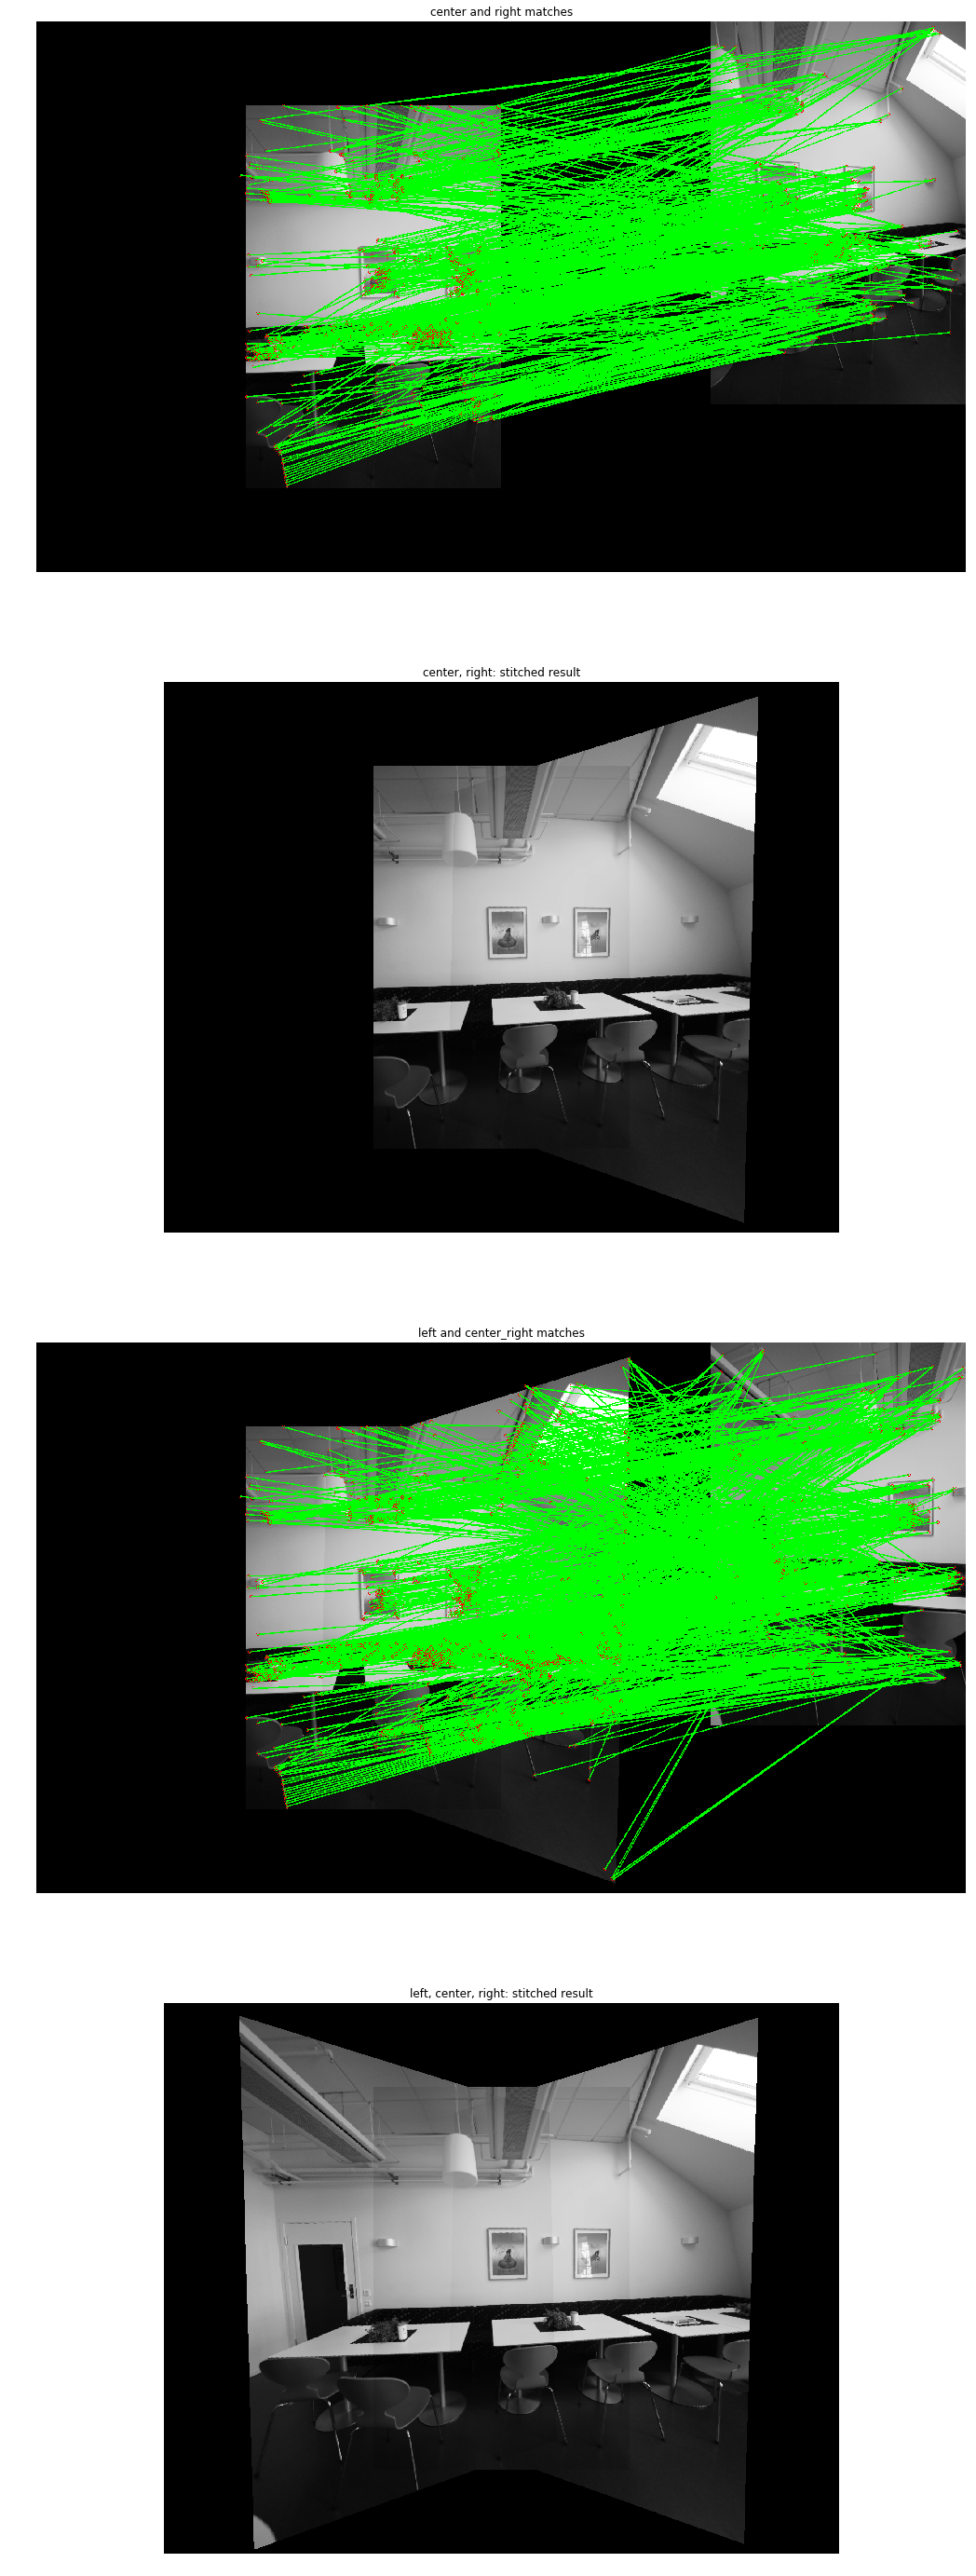

(-0.5, 1607.5, 1311.5, -0.5)

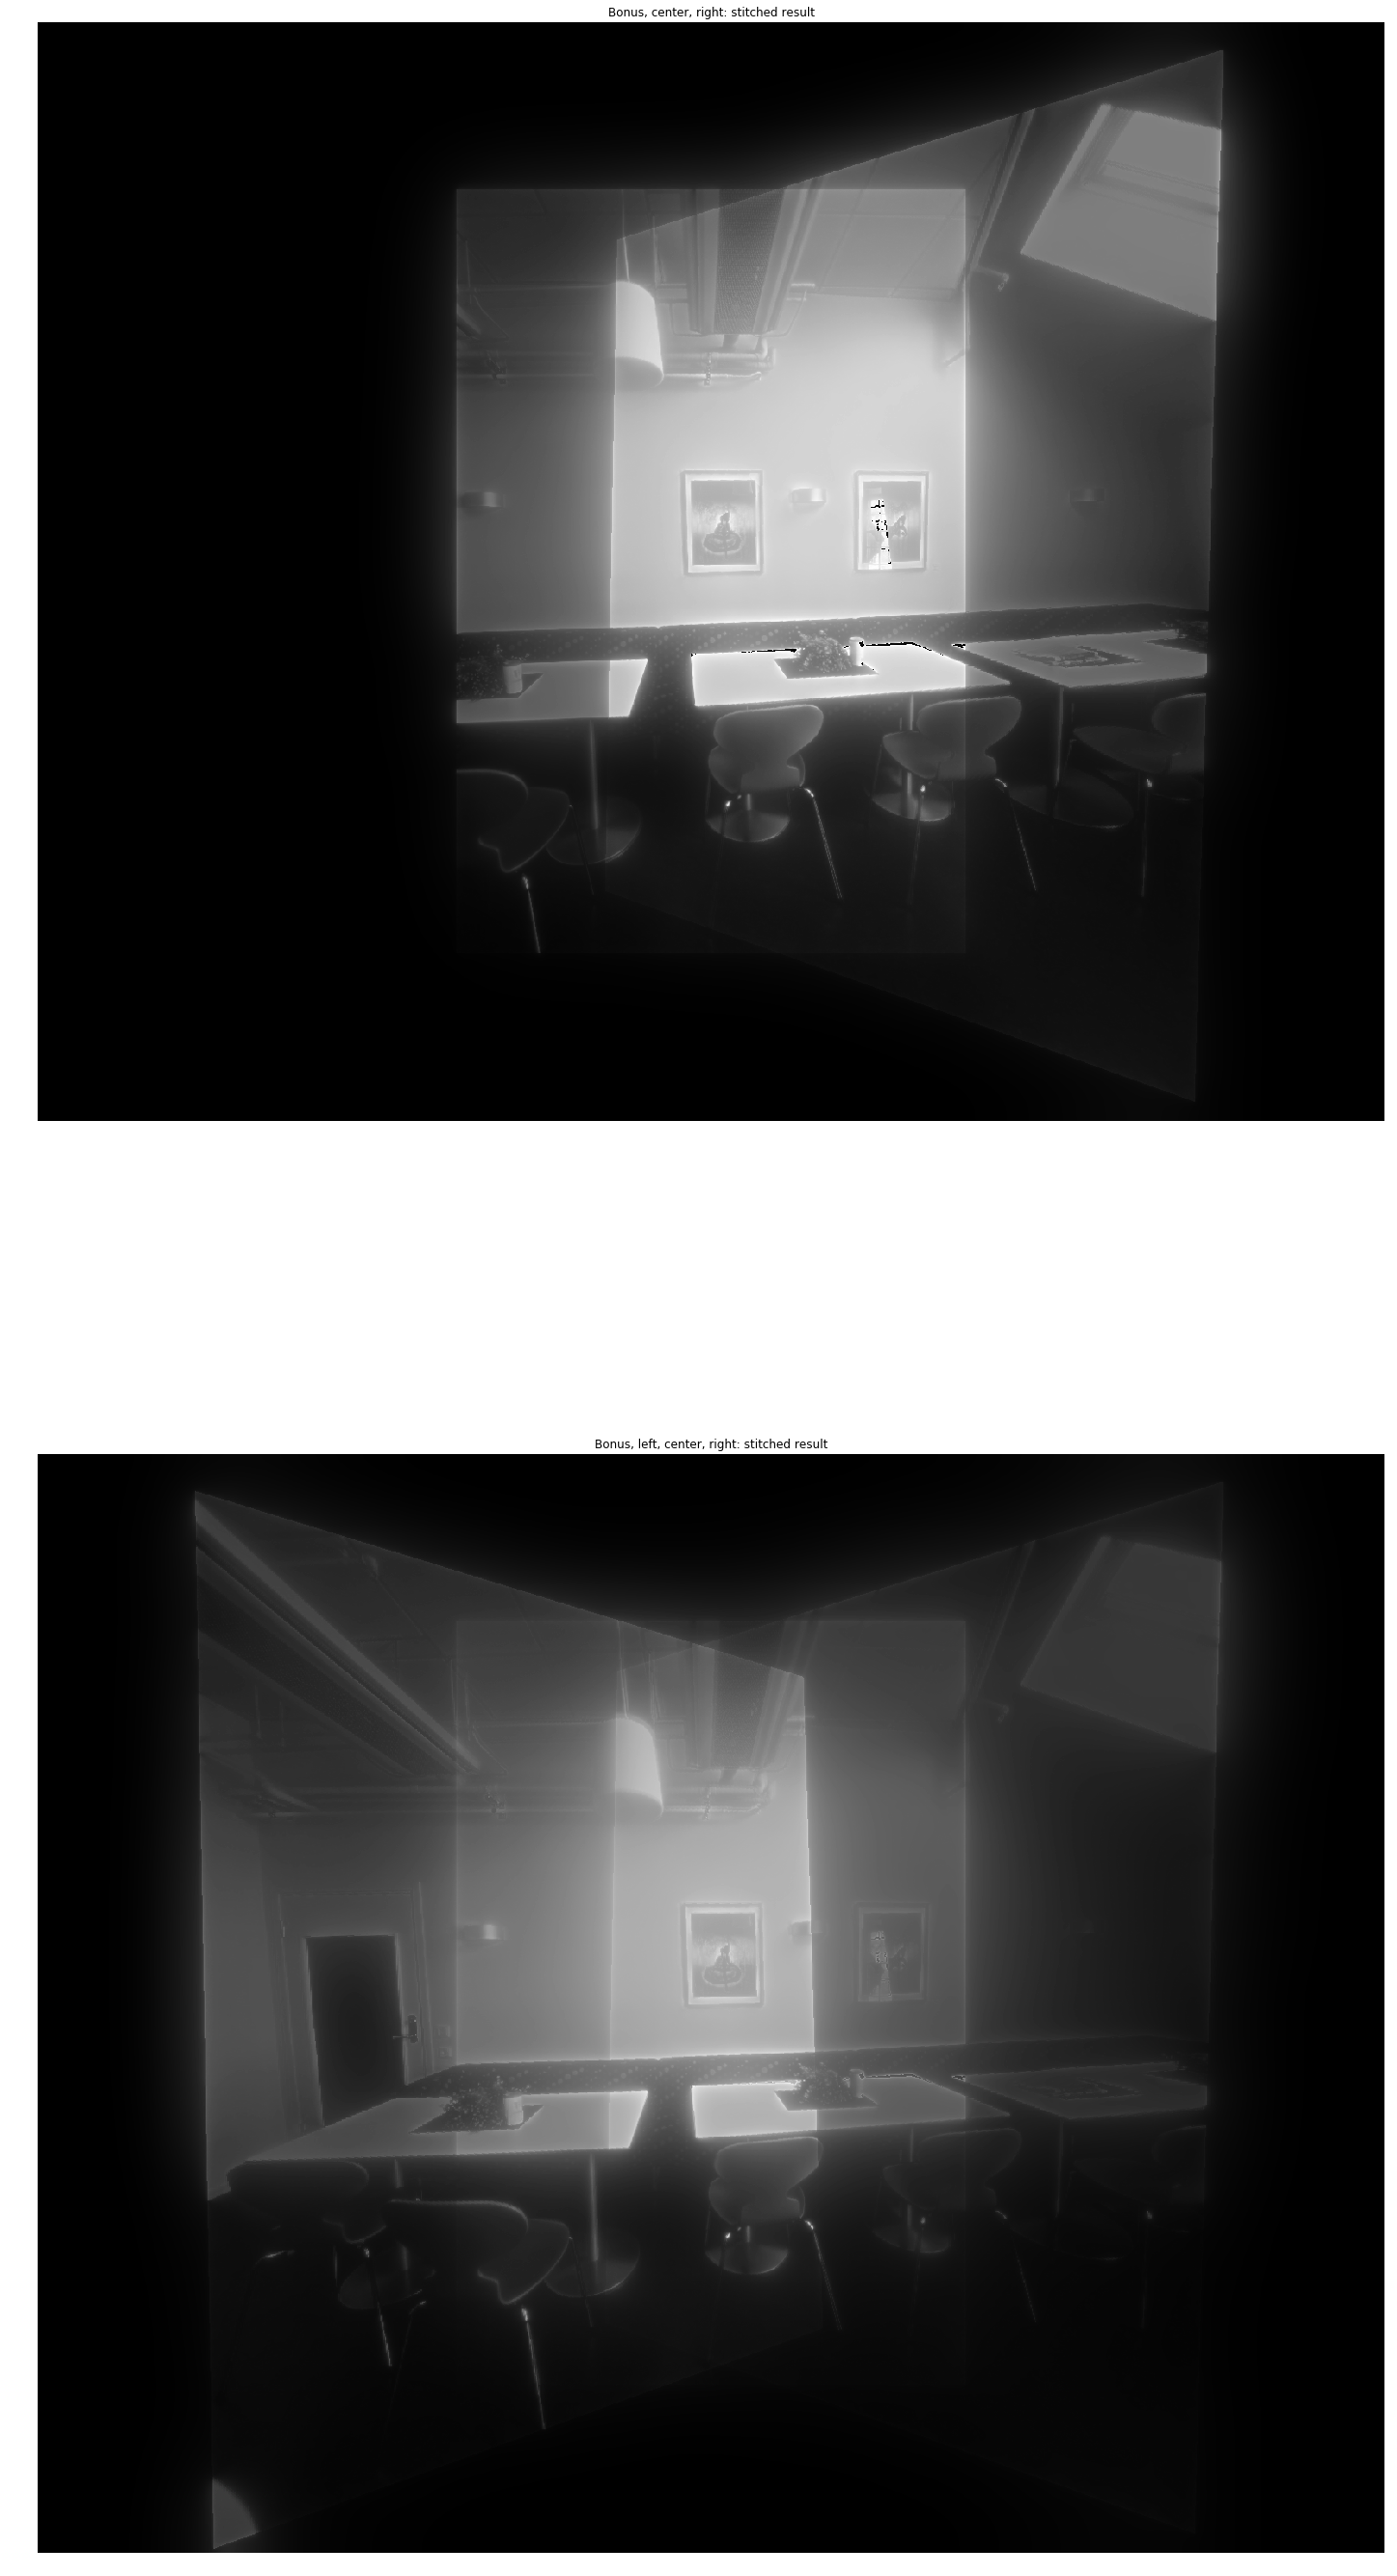

In [27]:
imgCenter = cv2.imread('SourceImages/stitch_m.png', 0)
imgRight  = cv2.imread('SourceImages/stitch_r.png', 0)
imgLeft   = cv2.imread('SourceImages/stitch_l.png', 0)

# initalize the stitched image as the center image
imgCenter = cv2.copyMakeBorder(imgCenter,200,200,500,500,cv2.BORDER_CONSTANT)

def toImage(img_input):
    img_input.astype(np.uint8)
    new_image_red =img_input
    new_image_blue = img_input
    new_image_green=img_input
    new_rgb = np.dstack([new_image_red, new_image_green, new_image_blue])
    img_input=new_rgb
    img_input=img_input.astype(np.uint8)
    img_input=cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    return img_input

def OverLap(img1,img2):
    imgMask1=np.zeros(img1.shape, dtype=int)
    imgMask2=np.zeros(img2.shape, dtype=int)
    imgMask_total=np.zeros(img1.shape, dtype='uint8')
    rows1=imgMask1.shape[0]
    cols1=imgMask2.shape[1]
    for x in range(0, rows1):
        for y in range(0, cols1):
            if (img1[x][y]!=0):
                imgMask1[x][y]=-1
            if(img2[x][y]!=0):
                imgMask2[x][y]=-1
    for x in range(0, rows1):
        for y in range(0, cols1):
            if (imgMask1[x][y]==-1 & imgMask2[x][y]==-1):
                imgMask_total[x][y]= 255
    imgMask_total=imgMask_total.astype('uint8')
    return imgMask_total

def alpha_blend(img, warped):
    overLap_range=OverLap(img,warped) # overlap index range 
    overLap_img=np.zeros(img.shape, dtype='uint8')
    overLap_warped=np.zeros(img.shape, dtype='uint8')
    NonoverLap_img=np.zeros(img.shape, dtype='uint8')
    NonoverLap_warped=np.zeros(img.shape, dtype='uint8')
    row=img.shape[0]
    col=img.shape[1]
    for x in range(0, row):
        for y in range(0, col):
            if (overLap_range[x][y]==255):
                overLap_img[x][y]=img[x][y]
                overLap_warped[x][y]=warped[x][y]
            if(overLap_range[x][y]!=255):
                NonoverLap_img[x][y]=img[x][y]
                NonoverLap_warped[x][y]=warped[x][y]
    blended=NonoverLap_img+NonoverLap_warped+0.5*overLap_img+0.5*overLap_warped
    return blended

def np_flip(A):
    arr=[]
    for i in range(A.size-1,0,-1):
        arr.append(A[i])
    arr=np.asarray(arr)
    return arr
    


def generateLaplacian(A,B,num_levels):
    G = A.copy()
    gpA = [G] 
    for i in xrange(0,num_levels):
        G = cv2.pyrDown(gpA[i])
        gpA.append(G)   
    G = B.copy()
    gpB = [G]
    for i in xrange(0,num_levels):
        G = cv2.pyrDown(gpB[i])
        gpB.append(G)
#     print(len(gpA))
#     for i in xrange(0, len(gpA)):
#         print("the laplacian of A is "+ str(gpA[i].shape))
    
 # generate Laplacian Pyramid for A
    lpA = [gpA[len(gpA)-1]]
    for i in xrange(len(gpA)-1,0,-1):
        size = (gpA[i-1].shape[1], gpA[i-1].shape[0]) 
        GE = cv2.pyrUp(gpA[i], dstsize = size)
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)
# generate Laplacian Pyramid for B
    lpB = [gpB[len(gpB)-1]]
    for i in xrange(len(gpB)-1,0,-1):
        size = (gpB[i-1].shape[1], gpB[i-1].shape[0])
        GE = cv2.pyrUp(gpB[i], dstsize = size)
        L = cv2.subtract(gpB[i-1],GE)
        lpB.append(L)
#     for i in range (0, len(lpA)):
#         print(lpA[i].shape)
    return lpA, lpB

def blend(lpA, lpB, mask):
    blended_pyr= []
    k=len(lpA)
    for i in range(0,k):
        p1=lpA[i]*mask
        p2=lpB[i]*(1-mask)
        blended_pyr.append(p1 + p2)
    return blended_pyr





def reconstruct(lapl_pyr):
    output = None
    output = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
    for i in range(len(lapl_pyr)-1,0,-1):
        lapb = lapl_pyr[i-1]
        size=(lapb.shape[1],lapb.shape[0])
        lap = cv2.pyrUp(lapl_pyr[i],dstsize=size) 
        if lap.shape[0] > lapb.shape[0]:
            lap = np.delete(lap,(-1),axis=0)
        if lap.shape[1] > lapb.shape[1]:
            lap = np.delete(lap,(-1),axis=1)
#         tmp=alpha_blend(lap, lapb)
        tmp = lap + lapb
        lapl_pyr.pop()
        lapl_pyr.pop()
        lapl_pyr.append(tmp)
        output = tmp
    return output






def Laplacian_Blending(A, B, mask, num_levels):
    lpA,lpB=generateLaplacian(A,B,num_levels)
    lpA=np.asarray(lpA)
    lpB=np.asarray(lpB)
    blended_pyr=blend(lpA,lpB,mask)    
    blended_pyr_reverse=[]
    for i in range(len(blended_pyr)-1,-1,-1):
        blended_pyr_reverse.append(blended_pyr[i])
    
    blended=reconstruct(blended_pyr_reverse)
    return blended

def getTransform(img1, img2): 
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good_matches = [] 
    for m,n in matches:
        if m.distance < 1*n.distance:
            good_matches.append(m)
    img_match=drawMatches(img1, kp1, img2, kp2, good_matches)
    if len(good_matches) > 4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0) #cv2.RANSAC
    else:
        print "Not enough matches are found - %d/%d" % (len(good_matches),4)
    return H,img_match

def perspective_warping(imgCenter, imgLeft, imgRight):    
    T_R2C, img_match1 = getTransform(imgCenter,imgRight)
    row=imgCenter.shape[0]
    col=imgCenter.shape[1]
    warp_right=cv2.warpPerspective(imgRight, T_R2C, (col,row), cv2.WARP_FILL_OUTLIERS, 200) # right image warped
    stitched_cr=alpha_blend(imgCenter, warp_right)
    stitched_cr=toImage(stitched_cr)
    T_L2CR, img_match2 = getTransform(stitched_cr,imgLeft)
    warp_left=cv2.warpPerspective(imgLeft, T_L2CR, (col,row), cv2.WARP_FILL_OUTLIERS, 200)
    stitched_res=alpha_blend(stitched_cr, warp_left)
    return stitched_res, stitched_cr, img_match1, img_match2

    
def perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight):
    T_R2C, img_match1 = getTransform(imgCenter,imgRight)
    row=imgCenter.shape[0]
    col=imgCenter.shape[1]
    warp_right=cv2.warpPerspective(imgRight, T_R2C, (col,row), cv2.WARP_FILL_OUTLIERS, 200) # right image warped
    stitched_cr=Laplacian_Blending(imgCenter,warp_right,0.5,6)  
    stitched_cr=toImage(stitched_cr)
    T_L2CR, img_match2 = getTransform(stitched_cr,imgLeft)
    warp_left=cv2.warpPerspective(imgLeft, T_L2CR, (col,row), cv2.WARP_FILL_OUTLIERS, 200)
    stitched_res=Laplacian_Blending(stitched_cr, warp_left,0.5,6)
    return stitched_res, stitched_cr



# ====== Plot functions, DO NOT CHANGE =====
stitched_res, stitched_cr, img_match1, img_match2 = perspective_warping(imgCenter, imgLeft, imgRight)
stitched_res_lap, stitched_cr_lap = perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight)
        
plt.figure(figsize=(25,50))
plt.subplot(4, 1, 1)
plt.imshow(img_match1,'gray')
plt.title("center and right matches")
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(stitched_cr,'gray')
plt.title("center, right: stitched result")
plt.axis('off')
plt.subplot(4, 1, 3)
plt.imshow(img_match2,'gray')
plt.title("left and center_right matches")
plt.axis('off')
plt.subplot(4, 1, 4)
plt.imshow(stitched_res,'gray')
plt.title("left, center, right: stitched result")
plt.axis('off')
plt.show()

plt.figure(figsize=(25,50))
plt.subplot(2, 1, 1)
plt.imshow(stitched_cr_lap,'gray')
plt.title("Bonus, center, right: stitched result")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(stitched_res_lap,'gray')
plt.title("Bonus, left, center, right: stitched result")
plt.axis('off')


## Problem 3: Object Recognition with HOG features
{30 points} You will use the histogram of oriented gradients (HOG) to extract features from objects and recognize them.

HOG decomposes an image into multiple cells, computes the direction of the gradients for all pixels in each cell, and creates a histogram of gradient orientation for that cell. Object recognition with HOG is usually done by extracting HOG features from a training set of images, learning a support vector machine (SVM) from those features, and then testing a new image with the SVM to determine the existence of an object.

You can use `cv2.HOGDescriptor` to extract the HoG feature and `cv2.ml.SVM_create` for SVMs (and a lot of other algorithms). You can also use Python machine learning packages for SVM, e.g.`scikit-learn` and for HoG computation, e.g. `scikit-image`. Please find the OpenCV SVM tutorial at https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/.

An image set located under SourceImages/human_vs_cars is provided containing 20 images. You will first train an SVM with the HoG features and then predict the class of an image with the trained SVM. For simplicity, we will be dealing with a binary classification problem with two classes, namely, cars and humans. There are 10 images for each class.

Some of the function names and arguments are provided, you may change them as you see fit.

- **Step 1 (5pts)**. Load in the images and create a vector of corresponding labels (0 for car and 1 for human). An example label vector should be something like [1,1,1,1,1,0,0,0,0,0]. Shuffle the images randomly and display them in a 2 x 10 grid with figsize = (18, 15).

- **Step 2 (10pts)**. Extract HoG features from all images. You can use the OpenCV function `cv2.HOGDescriptor` or hog routine from `scikit-image`. Display the HoG features for all images in a 2 x 10 grid with figsize = (18, 15).

- **Step 3**. Use the first 16 examples from the shuffled dataset as training data on which to train an SVM. The rest 4 are used as test data. Reshape the HoG feature matrix as necessary to feed into the SVM. Train the classifier. **DO NOT train with test data.** No output is expected from this part.

- **Step 4 (15pts)**. Perform predictions with your trained SVM on the test data. Output a vector of predictions, a vector of ground truth labels, and prediction accuracy.

In [4]:
# import skimage.exposure
# from skimage.feature import hog
# from sklearn.svm import LinearSVC
import glob


# load data+
def loadData(file):
    for name in glob.glob(file+'*[0-9]*'):
        print name
    

                          
    # Implement your loadData(file) here

loadData('SourceImages/human_vs_cars/car_')
loadData('SourceImages/human_vs_cars/human_')

# ===== Display your first graph here =====

# create a vector of labels
# assume labels: car = 0, human = 1

SourceImages/human_vs_cars\car_1.png
SourceImages/human_vs_cars\car_10.png
SourceImages/human_vs_cars\car_2.png
SourceImages/human_vs_cars\car_3.png
SourceImages/human_vs_cars\car_4.png
SourceImages/human_vs_cars\car_5.png
SourceImages/human_vs_cars\car_6.png
SourceImages/human_vs_cars\car_7.png
SourceImages/human_vs_cars\car_8.png
SourceImages/human_vs_cars\car_9.png
SourceImages/human_vs_cars\human_1.png
SourceImages/human_vs_cars\human_10.png
SourceImages/human_vs_cars\human_2.png
SourceImages/human_vs_cars\human_3.png
SourceImages/human_vs_cars\human_4.png
SourceImages/human_vs_cars\human_5.png
SourceImages/human_vs_cars\human_6.png
SourceImages/human_vs_cars\human_7.png
SourceImages/human_vs_cars\human_8.png
SourceImages/human_vs_cars\human_9.png


In [ ]:
# Compute HOG features for the images
def computeHOGfeatures():

    # Implement your computeHOGfeatures() here

# Compute HOG descriptors

# ===== Display your second graph here =====

# reshape feature matrix

# Split the data and labels into train and test set

In [ ]:
# train model with SVM
# call LinearSVC
# train SVM
# call clf.predict

# ===== Output functions ======
print('estimated labels: ', # fill in here #)
print('ground truth labels: ', # fill in here #)
print('Accuracy: ', # fill in here #, '%')

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them. The image read and write functions are already written for you. All you need to do is to write the codes to generate proper outputs and display them.

When submitting your .zip file through blackboard, please <br> 
-- name your .zip file as Surname_Givenname_SBUID (example: Trump_Donald_11113456). <br>
-- DO NOT change the folder structre, please just fill in the blanks. <br>

You are encouraged to make posts and answer questions on Piazza. Due to the amount of emails I receive from past years, it is unfortunate that I won't be able to reply all your emails. Please ask questions on Piazza and send emails only when it is private.

To encourage you to answer questions on piazza, the three persons answering the most questions will be awarded extra 5 points at the end of the semester.

If you alter the folder strucutres, the grading of your homework will be significantly delayed and possibly penalized. And I **WILL NOT** reply to any email regarding this matter.

Be aware that your codes will undergo plagiarism checker both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.